# POS tagging with HMMs and Viterbi algorithm

In [41]:
from collections import defaultdict
import nltk, re, pprint, time
import pandas as pd
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sklearn
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers

In [42]:
from nltk.corpus import brown

In [43]:
# set the random seed
random.seed(1)

# split data into training and test data. The train data correspond to the 95% of the whole amount of data
train_data, test_data = train_test_split(brown.tagged_sents(tagset='universal'), train_size=0.80, random_state = 1)

# Getting list of tagged words in training set
train_tagged_words = [pair for sent in train_data for pair in sent]   # list of tuples corresponding to the tagged words

# Getting list of tagged words in test set
test_tagged_words = [pair for sent in test_data for pair in sent]

# saves all sentences in the data
all_sent = [sent for sent in brown.tagged_sents(tagset='universal')]

# saves all tagged words
all_tagged_words = [tuple for sent in brown.tagged_sents(tagset='universal') for tuple in sent]

The idea is to help the process of training by means of three different dictionaries:

1. *transition_dict*: it is a dictionary that will count the number of times a tags happened next to another tag. The keys are pairs of the form $(tag_1, tag_2)$ and, as the name suggests, it will be crucial in computing the transition probabilities matrix.

2. *emission_dict*: it is dictionary that stores how many times each pair $(word, tag)$ appears in the data. Those very pairs will be the keys of the dictionary. It will be helpful to compute the emission probability matrix.

3. *counting_tag*: this dictionary, whose keys are simply the 12 tags, will associate to each tag the corresponding frequency in the data.

The data structure that we will use is the *defaultdict* from the package *collections*.

In [44]:
# create the vocabulary of the words: for each word it stores the corresponding index in the ordered list of words

def create_vocabulary(train_tagged_words = train_tagged_words) :
    # list of words in training set
    train_words = [pair[0] for pair in train_tagged_words]

    # eliminate duplicates and sort the words
    words = sorted(list(set(train_words)))

    vocabulary = {}
    # Get the index of the corresponding words. 
    for i, word in enumerate(words): 
        vocabulary[word] = i    

    return vocabulary   

vocabulary = create_vocabulary()

# example words in the dictionary
print('Example words in the dictionary: ')
for i in range(10) :
    print(list(vocabulary.items())[i+50000])



Example words in the dictionary: 
('wilt', 50000)
('wilted', 50001)
('wily', 50002)
('win', 50003)
('winced', 50004)
('winches', 50005)
('wincing', 50006)
('wind', 50007)
('wind-and-water', 50008)
('wind-blown', 50009)


In [45]:
# create the set of test words (without tags)
test_words = [pair[0] for pair in test_tagged_words]

# and the one of test tags
test_tags = [pair[1] for pair in test_tagged_words]

In [46]:
def create_dictionaries(tagged_words = train_tagged_words) :
    """
    receives as input a list of tagged words and returns the three dictionaries decribed above
    """

    # initialize the dictionaries
    transition_dict = defaultdict(int)
    emission_dict = defaultdict(int)
    counting_dict = defaultdict(int)

    # at the beginning of the data we initialize the previous tag as '.'
    prev_tag = '.'

    # for each (word, tag) in the training data
    for word, tag in tagged_words :
        transition_dict[(prev_tag, tag)] += 1
        emission_dict[(word, tag)] += 1
        counting_dict[tag] += 1

        # set the previous tag equals to the current tag
        prev_tag = tag

    # sort the dictionaries in ascending order based on their keys
    counting_dict = dict(sorted(counting_dict.items())) 
    transition_dict = dict(sorted(transition_dict.items()))
    emission_dict = dict(sorted(emission_dict.items()))

    return transition_dict, emission_dict, counting_dict

In [47]:
transition_dict, emission_dict, counting_dict = create_dictionaries()

In [48]:
# counting_dict gives information about the POS tags in the training data and their frequencies
n_tags = len(counting_dict.keys())
print('Number of POS tags: ', n_tags)
tags = list(counting_dict.keys())
print(tags)
print('\n')

print('POS tags frequencies: ')
for key, value in counting_dict.items() :
    print('{}: {}'.format(key, value))

Number of POS tags:  12
['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


POS tags frequencies: 
.: 118075
ADJ: 67149
ADP: 115660
ADV: 45025
CONJ: 30520
DET: 109483
NOUN: 220494
NUM: 11916
PRON: 39401
PRT: 23913
VERB: 146018
X: 1107


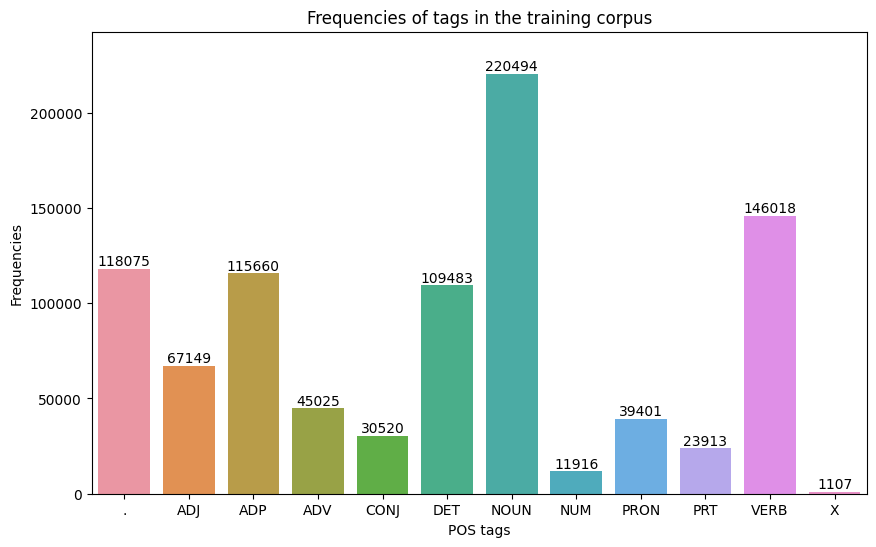

In [49]:
# plot the frequencies of tags in the training corpus

x = list(counting_dict.keys())
y = list(counting_dict.values())

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=x, y=y, ax=ax)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

ax.set_title('Frequencies of tags in the training corpus')
ax.set_ylabel('Frequencies')
ax.set_xlabel('POS tags')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

fig.savefig('tags_freq.png', bbox_inches='tight')

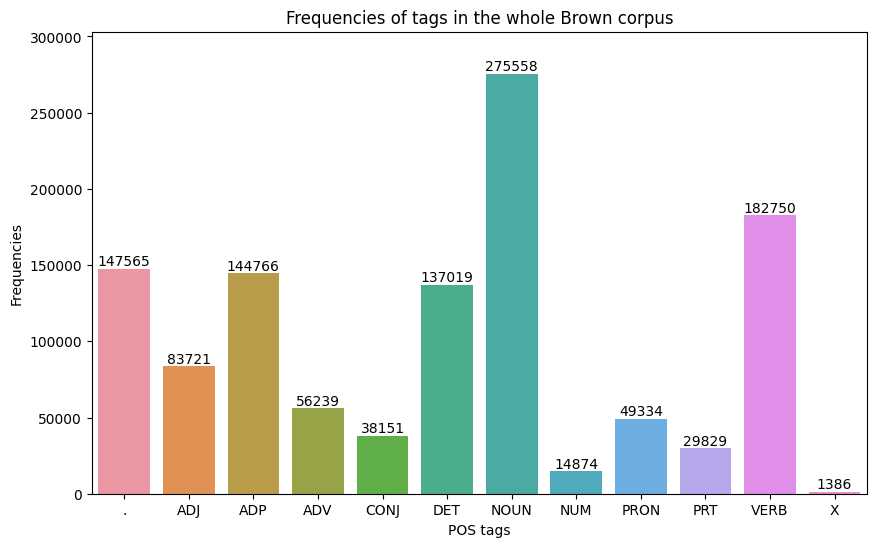

In [50]:
# and the same plot using all the data in the Brown data set

all_transition_dict, all_emission_dict, all_counting_dict = create_dictionaries(all_tagged_words)

# plot data
x = list(all_counting_dict.keys())
y = list(all_counting_dict.values())

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=x, y=y, ax=ax)

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

ax.set_title('Frequencies of tags in the whole Brown corpus')
ax.set_ylabel('Frequencies')
ax.set_xlabel('POS tags')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

fig.savefig('all_tags_freq.png', bbox_inches='tight')

In [51]:
print('The five most frequent POS tags are: ')
for i in range(5) :
    print(sorted(counting_dict.items(), key=lambda x:x[1], reverse=True)[i])

The five most frequent POS tags are: 
('NOUN', 220494)
('VERB', 146018)
('.', 118075)
('ADP', 115660)
('DET', 109483)


In [52]:
# Most frequent pairs (word, tag)

print('The most frequent pairs of (word, tag) are:')

for i in range(20) :
    print(sorted(emission_dict.items(), key=lambda x:x[1], reverse=True)[i])

The most frequent pairs of (word, tag) are:
(('the', 'DET'), 50128)
((',', '.'), 46642)
(('.', '.'), 39503)
(('of', 'ADP'), 28945)
(('and', 'CONJ'), 22307)
(('a', 'DET'), 17428)
(('in', 'ADP'), 15197)
(('to', 'PRT'), 11795)
(('to', 'ADP'), 8830)
(('is', 'VERB'), 7989)
(('was', 'VERB'), 7783)
(('for', 'ADP'), 7105)
(('``', '.'), 7093)
(("''", '.'), 7050)
(('The', 'DET'), 5767)
(('with', 'ADP'), 5551)
(('it', 'PRON'), 5361)
(('he', 'PRON'), 5267)
(('his', 'DET'), 5140)
(('that', 'ADP'), 5117)


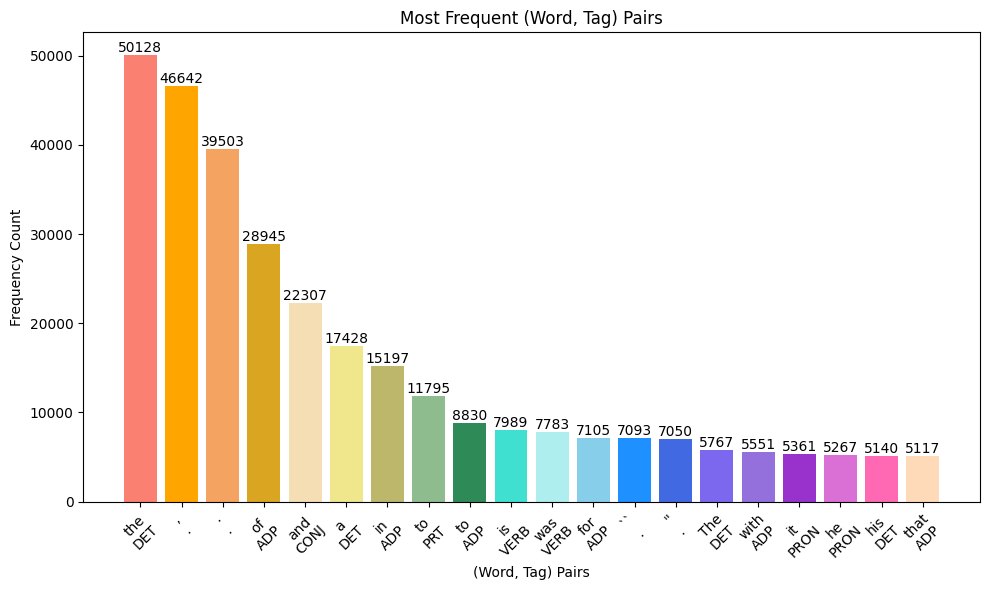

In [53]:
# bar chart of the to top_n pairs with the highest emission probability

# select the top_n pairs with the highest emission probability
top_n = 20
top_pairs = sorted(emission_dict.items(), key=lambda x:x[1], reverse=True)[:top_n]

# Extract the words and tags from the selected pairs
w = [pair[0][0] for pair in top_pairs]
t = [pair[0][1] for pair in top_pairs]
c = [pair[1] for pair in top_pairs]

colors = ['salmon','orange','sandybrown','goldenrod','wheat','khaki','darkkhaki','darkseagreen','seagreen','turquoise',
          'paleturquoise','skyblue','dodgerblue','royalblue','mediumslateblue','mediumpurple','darkorchid','orchid','hotpink', 'peachpuff']

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart to visualize the most frequent pairs, assigning colors to the bars
bars = ax.bar(range(top_n), c, color=colors)

# Customize the x-axis labels and tick rotation
plt.xticks(range(top_n), [f"{word}\n{tag}" for word, tag in zip(w, t)], rotation=45)

# Add labels to the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, c[i],
            ha='center', va='bottom')

# Set labels and title
plt.xlabel('(Word, Tag) Pairs')
plt.ylabel('Frequency Count')
plt.title('Most Frequent (Word, Tag) Pairs')

plt.tight_layout()
plt.savefig('most_freq_em.png')
plt.show()

In [54]:
# Most frequent transitions
print('The most frequent transitions prev_tag -> tag are:')

for i in range(12) :
    print(sorted(transition_dict.items(), key=lambda x:x[1], reverse=True)[i])

The most frequent transitions prev_tag -> tag are:
(('DET', 'NOUN'), 68528)
(('NOUN', '.'), 62622)
(('NOUN', 'ADP'), 53979)
(('ADP', 'DET'), 52587)
(('ADJ', 'NOUN'), 43815)
(('NOUN', 'VERB'), 35086)
(('NOUN', 'NOUN'), 33005)
(('ADP', 'NOUN'), 29997)
(('PRON', 'VERB'), 27782)
(('VERB', 'VERB'), 26899)
(('DET', 'ADJ'), 26292)
(('VERB', 'ADP'), 24677)


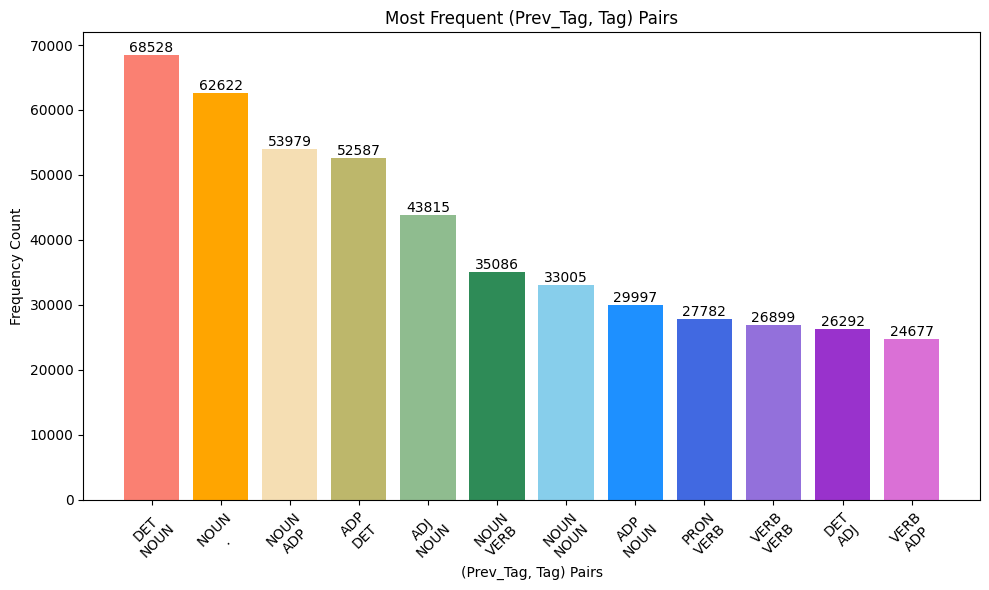

In [55]:
# bar chart of the top_n pairs with the highest emission probability

# select the top_n pairs with the highest emission probability
top_n = 12
top_pairs = sorted(transition_dict.items(), key=lambda x:x[1], reverse=True)[:top_n]

# Extract the words and tags from the selected pairs
w = [pair[0][0] for pair in top_pairs]
t = [pair[0][1] for pair in top_pairs]
c = [pair[1] for pair in top_pairs]

colors = ['salmon','orange','wheat','darkkhaki','darkseagreen','seagreen','skyblue','dodgerblue','royalblue','mediumpurple','darkorchid','orchid']

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar chart to visualize the most frequent pairs, assigning colors to the bars
bars = ax.bar(range(top_n), c, color=colors)

# Customize the x-axis labels and tick rotation
plt.xticks(range(top_n), [f"{word}\n{tag}" for word, tag in zip(w, t)], rotation=45)

# Add labels to the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, c[i],
            ha='center', va='bottom')

# Set labels and title
plt.xlabel('(Prev_Tag, Tag) Pairs')
plt.ylabel('Frequency Count')
plt.title('Most Frequent (Prev_Tag, Tag) Pairs')

plt.tight_layout()
plt.savefig('most_freq_tr.png')
plt.show()

In [56]:
# returns the words that appears with more tags and the number of that tags
more_tags_word = []
max_count = 0

em_list = [pair[0] for pair in emission_dict.keys()]

i = 1
while i < len(em_list) :
    count = 1
    while em_list[i] == em_list[i-1]:
        count += 1
        i += 1
    if count > max_count:
        max_count = count
        more_tags_word.clear()
        more_tags_word.append(em_list[i-1])
    elif count == max_count:
        more_tags_word.append(em_list[i-1])
    if count == 1:
        i += 1

print(max_count)
print(more_tags_word)
    

5
['damn', 'down', 'round', 'that', 'to', 'well']


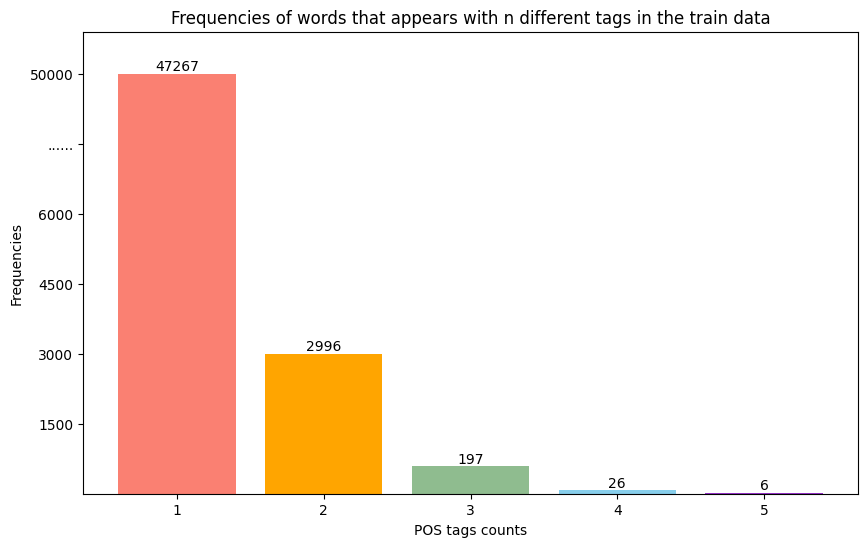

In [57]:
# evaluate the number of words that appear with 1-2-3-... tags and represent the result by means of a bar chart
word_tag_count = defaultdict(int)
for pair in emission_dict.keys():
    word_tag_count[pair[0]] += 1

tag_count = defaultdict(int)
for _, n in word_tag_count.items():
    tag_count[n] += 1

y = [count for count in tag_count.values()]
y[0] = 3000
y[1] = 1000

colors = ['salmon','orange','darkseagreen','skyblue','darkorchid']

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Customize the x-axis labels
plt.xticks(range(5), ['1', '2', '3', '4', '5'])
# Customize the y-axis labels
plt.yticks(np.arange( max(y)/6, max(y) +  max(y)/6, max(y)/6), ['1500', '3000', '4500', '6000', '......', '50000'])

# Create a bar chart to visualize the most frequent pairs, assigning colors to the bars
bars = ax.bar(range(len(tag_count.keys())), y, color=colors)

# Add labels to the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, list(tag_count.values())[i],
            ha='center', va='bottom')

ax.set_title('Frequencies of words that appears with n different tags in the train data')
ax.set_ylabel('Frequencies')
ax.set_xlabel('POS tags counts')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

fig.savefig('n_tags_freq.png', bbox_inches='tight')

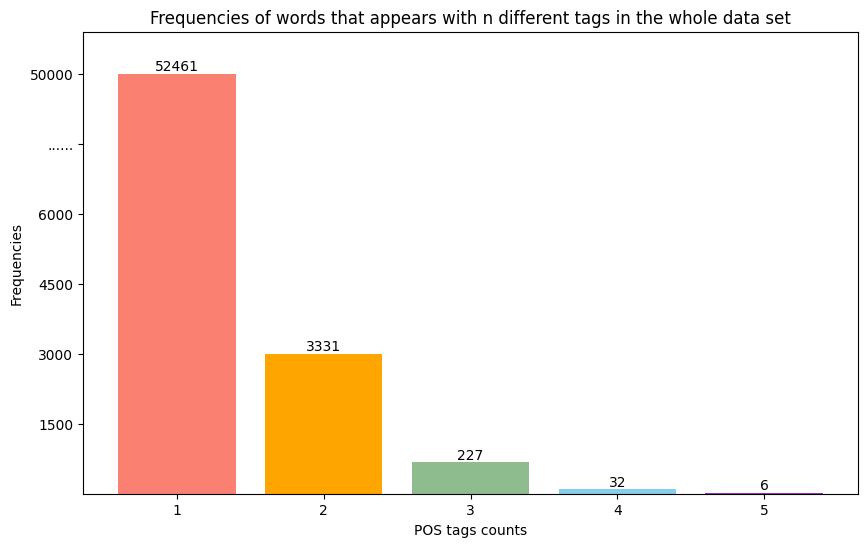

In [58]:
# does the same for all the words in the data set (training + test words)
all_word_tag_count = defaultdict(int)
for pair in all_emission_dict.keys():
    all_word_tag_count[pair[0]] += 1

all_tag_count = defaultdict(int)
for _, n in all_word_tag_count.items():
    all_tag_count[n] += 1

all_tag_count = dict(sorted(all_tag_count.items())) 

y = [count for count in all_tag_count.values()]
y[0] = 3000
y[1] = 1000

colors = ['salmon','orange','darkseagreen','skyblue','darkorchid']

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Customize the x-axis labels
plt.xticks(range(5), ['1', '2', '3', '4', '5'])
# Customize the y-axis labels
plt.yticks(np.arange( max(y)/6, max(y) +  max(y)/6, max(y)/6), ['1500', '3000', '4500', '6000', '......', '50000'])

# Create a bar chart to visualize the most frequent pairs, assigning colors to the bars
bars = ax.bar(range(len(all_tag_count.keys())), y, color=colors)

# Add labels to the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, list(all_tag_count.values())[i],
            ha='center', va='bottom')

ax.set_title('Frequencies of words that appears with n different tags in the whole data set')
ax.set_ylabel('Frequencies')
ax.set_xlabel('POS tags counts')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)

fig.savefig('all_n_tags_freq.png', bbox_inches='tight')

Moreover the *emission_dict* dictionary allows also to have a look to ambiguous words, i.e. words that happear with more than one tag.

In [59]:
# ambiguous words

n_words = len(vocabulary.keys())
n_ambiguous_words = len(emission_dict.keys()) - n_words
print('Number of ambiguous words', n_ambiguous_words)
print('Percentage of ambiguous words', n_ambiguous_words/n_words)

Number of ambiguous words 3492
Percentage of ambiguous words 0.0691594708072566


In [60]:
# example of ambiguous word

print('Example of an ambiguous word: ')

for pair, count in emission_dict.items() :
    if pair[0] == 'well': 
        print(pair, count)

Example of an ambiguous word: 
('well', 'ADJ') 11
('well', 'ADV') 552
('well', 'NOUN') 15
('well', 'PRT') 21
('well', 'VERB') 4


The final analysis on the data concerns identifying the number of words that appear just one time in all the training corpus

In [61]:
# words that appear just one time in all the training corpus

# words in the training corpus
train_words = [pair[0] for pair in train_tagged_words]
# corresponding tags
train_tags = [pair[1] for pair in train_tagged_words]

# Count the occurrences of each word
word_counts = defaultdict()
for word in train_words:
    word_counts[word] = word_counts.get(word, 0) + 1

# Find the words that appear only once
unique_words = [word for word, count in word_counts.items() if count == 1]

print(len(unique_words))

23374


## Emission and transition probability matrices

The computed dictionaries will be particularly useful to easily evaluate the emission probabilities and the transition probability matrix.

### Emission probability matrix
It is a $n_{tags} \times n_{words}$ matrix that stores the probability that given a certain tag, $tag$ the corresponding word is $word$.
The emission probability of $word$ given $tag$ is computed as:
$$
    p(word|tag) = \frac{\#\{\text{times the pair }(word, tag)\text{ is observed}\}}{\#\{\text{times any pair }(\cdot, tag)\text{ is observed}\}}
$$
Where $\#\{\text{times the pair }(word, tag)\text{ is observed}\}$ corresponds to the value of the key $(word, tag)$ in dictionary emission\_dict - if present, else it is zero - and $\#\{\text{times any pair }(\cdot, tag)\text{ is observed}\}$ corresponds to the value of the key $tag$ in counting\_dict.

In [62]:
def emission_prob_matrix(emission_dict = emission_dict, counting_dict = counting_dict, vocabulary = vocabulary) :
    '''
    compute the emission probability matrix
    '''
    # save the number of POS tags and of unique words
    n_tags = len(counting_dict.keys())
    n_words = len(vocabulary.keys())
    n_em = len(emission_dict.values())

    tags = list(counting_dict.keys())
    tags_freq = list(counting_dict.values())
    words = list(vocabulary.keys())

    em_pair = list(emission_dict.keys())
    em_freq = list(emission_dict.values())

    epm = np.zeros((n_tags, n_words), dtype = np.float64)

    cnt = 0
    for j, word in enumerate(words) :
        for i, tag in enumerate(tags) :
            if em_pair[cnt] == (word, tag) :
                #epm[i,j] = em_freq[cnt]/tags_freq[i]
                epm[i,j] = math.log(em_freq[cnt]) - math.log(tags_freq[i])
                cnt += 1
            else :
                epm[i,j] = float('-inf')
            if cnt >= n_em :
                break

    return epm

In [63]:
epm = emission_prob_matrix()

epm_df = pd.DataFrame(epm, index = tags, columns = vocabulary.keys())

In [64]:
# visualization of the emission probability matrix
cnt = 0
for key in vocabulary.keys():
    if key == 'well':
        break
    cnt +=1
    
truncated_epm_df = pd.DataFrame(epm[:,cnt-11:cnt+1], index = tags, columns = list(vocabulary.keys())[cnt-11:cnt+1])
pd.set_option('display.precision', 8)
print(truncated_epm_df)

           weird      weirdly        weirs      welcome    welcomed   
.           -inf         -inf         -inf         -inf        -inf  \
ADJ  -9.16875916         -inf         -inf  -8.62976266        -inf   
ADP         -inf         -inf         -inf         -inf        -inf   
ADV         -inf -10.71497317         -inf         -inf        -inf   
CONJ        -inf         -inf         -inf         -inf        -inf   
DET         -inf         -inf         -inf         -inf        -inf   
NOUN        -inf         -inf -12.30362576 -10.10640119        -inf   
NUM         -inf         -inf         -inf         -inf        -inf   
PRON        -inf         -inf         -inf         -inf        -inf   
PRT         -inf         -inf         -inf         -inf        -inf   
VERB        -inf         -inf         -inf  -9.49358991 -9.58890009   
X           -inf         -inf         -inf         -inf        -inf   

         welcomes    welcoming         weld       welded      welding   
.  

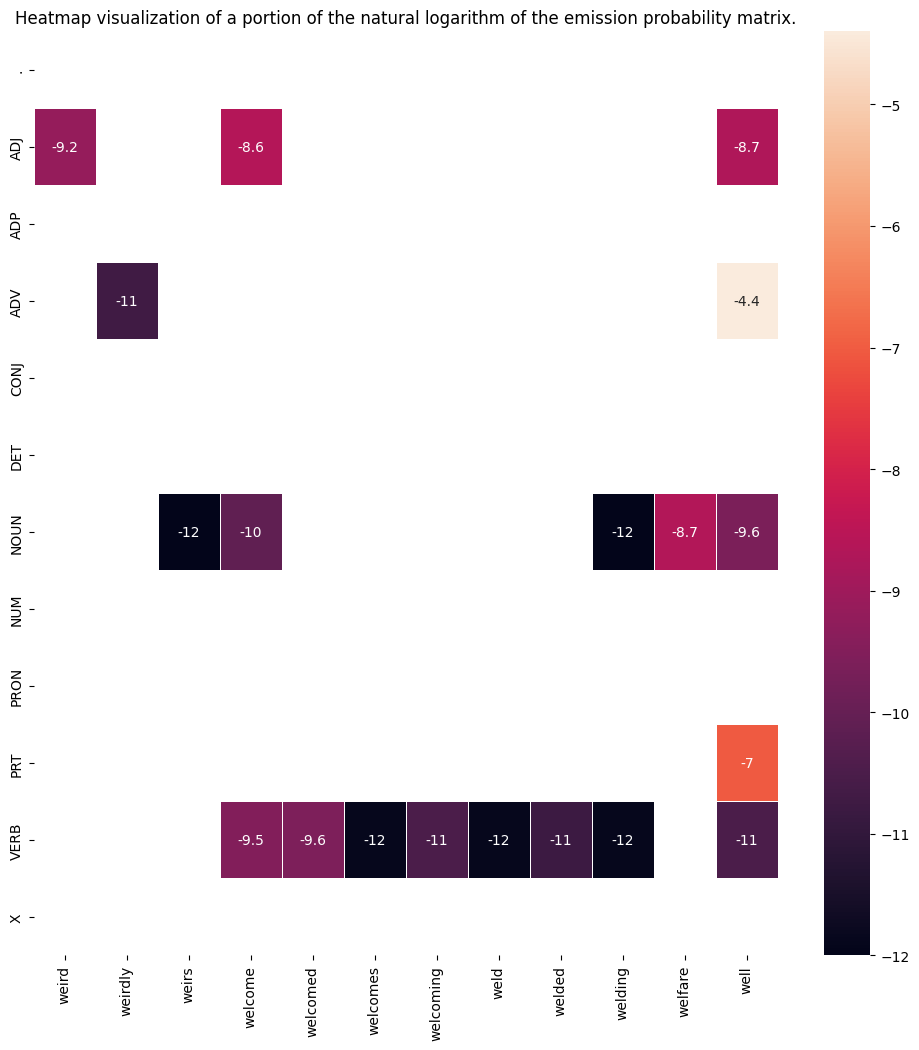

In [65]:
# sample figsize in inches
plt.figure(figsize=(12,12))

sns.heatmap(truncated_epm_df, annot = True, linewidths = .5, xticklabels = True, yticklabels = True, vmin = -12, vmax = -4.4)
plt.title('Heatmap visualization of a portion of the natural logarithm of the emission probability matrix.')
#plt.subtitle('The natural logarithm of the non-zero entries is considered. The zero values represents zero emission probability')
plt.savefig('truncated_epm.png', bbox_inches='tight')
plt.show()

### Transition probability matrix:

It is a $n_{tags} \times n_{tags}$ matrix that stores the probability that given a certain tag, $prev\_tag$, the following one is $tag$. Each entry of the matrix is evaluated as:
$$
p(tag|prev\_tag) = \frac{\#\{\text{times the tag $tag$ is observed after $prev\_tag$}\}}{\#\{\text{times the tag $prev\_tag$ is observed}\}}
$$
Where \#\{times the tag $tag$ is observed after $prev\_tag$ \} corresponds to the value of the key $(prev\_tag, tag)$ in the dictionary transition\_dict - if present, else it is zero - and \#\{times the tag $prev\_tag$ is observed\} is the value of the key $prev\_tag$ in counting\_dict.

In [66]:
def transition_prob_matrix(transition_dict = transition_dict, counting_dict = counting_dict) :
    '''
    compute the transition probability matrix
    '''
    # save the number of POS tags
    n_tags = len(counting_dict.keys())
    # and the one of transiotion probabilities
    n_trans = len(transition_dict.values())

    # if the matrix of transition probabilities is full
    if n_trans == n_tags * n_tags :
        # reshape the keys of the transition_dict dictionary to create a n_tags x n_tags matrix containing the frequencies of the transitions
        # in particular, row 1 will contain all the trainsition from stage '.', rwo 2 from 'ADJ', ...
        tpm = np.array([value for _, value in transition_dict.items()]).reshape(n_tags, n_tags)

        # extract the values of the counting_dict dictionary. The i-th row of the matrix tpm needs to be divided by the 
        # total counting of the tag from which the transition is performed - i.e. the i-th value of the following vector 
        tot = np.array([value for _, value in counting_dict.items()]).reshape(n_tags,1)

        tpm = tpm / tot

    else :
        tags = list(counting_dict.keys())
        tags_freq = list(counting_dict.values())
        tr_pair = list(transition_dict.keys())
        tr_freq = list(transition_dict.values())

        tpm = np.zeros((n_tags, n_tags), dtype = np.float64)

        cnt = 0
        for i, prev_tag in enumerate(tags) :
            for j, tag in enumerate(tags) :
                if tr_pair[cnt] == (prev_tag, tag) :
                    tpm[i,j] = tr_freq[cnt]/tags_freq[i]
                    cnt += 1
                if cnt >= n_trans :
                    break
    
    return tpm 


In [67]:
# transition probability matrix
tpm = transition_prob_matrix()

# visualization of the transition probability matrix
tpm_df = pd.DataFrame(tpm, index = tags, columns = tags)
print(tpm_df)


               .         ADJ         ADP         ADV        CONJ         DET   
.     0.14111370  0.04213424  0.11118357  0.07879737  0.08774931  0.14876138  \
ADJ   0.10016530  0.05764792  0.08866848  0.00978421  0.03746891  0.00591223   
ADP   0.00976137  0.08326993  0.02016255  0.01577901  0.00184160  0.45466886   
ADV   0.16872848  0.13641310  0.14103276  0.09699056  0.01783454  0.07460300   
CONJ  0.02067497  0.11179554  0.07287025  0.09125164  0.00022936  0.15160550   
DET   0.01275997  0.24014687  0.00914297  0.01748217  0.00065764  0.00603747   
NOUN  0.28400773  0.01325206  0.24480938  0.02649959  0.05996989  0.01598683   
NUM   0.27509231  0.05924807  0.13183954  0.02165156  0.03742867  0.01426653   
PRON  0.10372833  0.00964443  0.05611533  0.05411030  0.01144641  0.01776605   
PRT   0.07782378  0.01823276  0.09099653  0.03617279  0.01250366  0.08413833   
VERB  0.08061335  0.05738334  0.16899971  0.10319276  0.01444342  0.16350039   
X     0.28364950  0.00271003  0.05149051

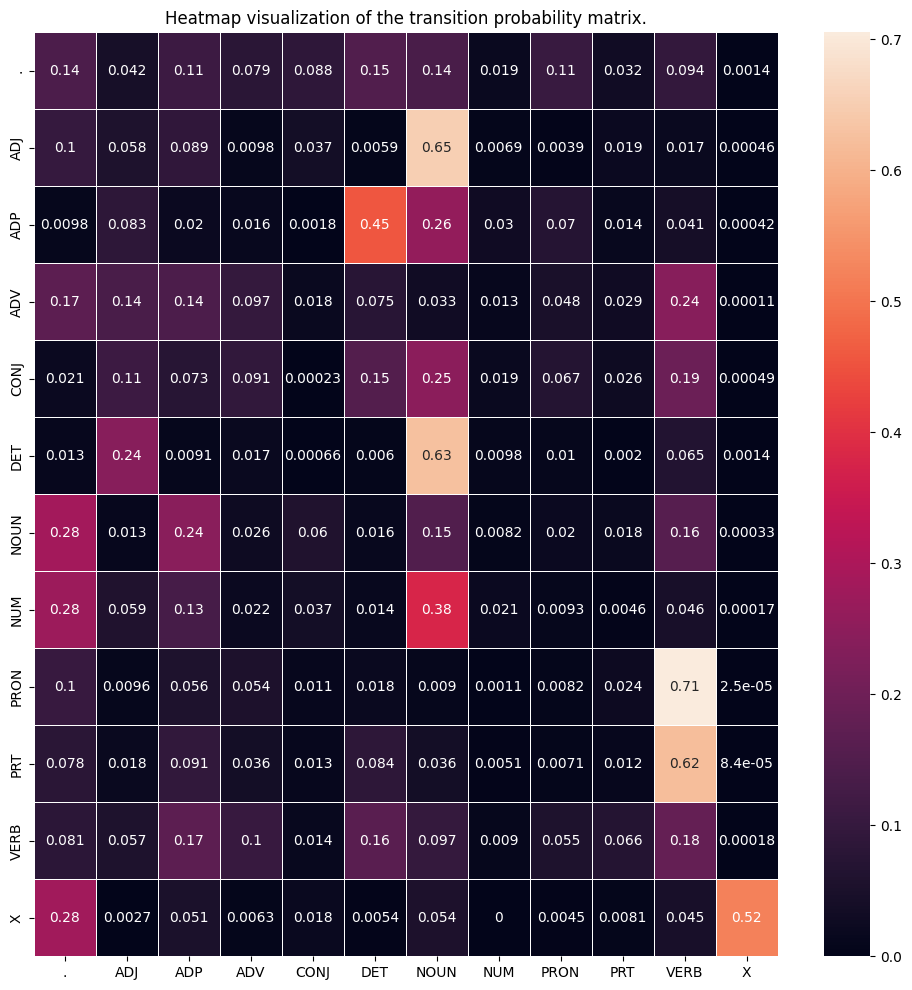

In [68]:
# sample figsize in inches
plt.figure(figsize=(12,12))

sns.heatmap(tpm_df, annot = True, linewidths = .5, xticklabels = True, yticklabels = True)
plt.title('Heatmap visualization of the transition probability matrix.')
plt.savefig('tpm.png', bbox_inches='tight')
plt.show()

# Viterbi algorithm

The pseudocode of the algorithm is reported here with some useful notation.

The algorithm returns the most probable sequence of tags $X = (x_0, \dots, x_n)$, where $x_i \in S = \{s_1, \dots, s_K\}, \,\, \forall i = 0, \dots n$ and $S$ is the state space - i.e. the set of all possible POS tags.

Let $Y = (y_0, \dots, y_n)$ be the sequence of observations, where $y_i \in W = \{w_1, \dots, w_N\}, \,\, \forall i = 1, \dots, n$ and $W$ is the observation space - i.e. the vocabulary of all *known* words.

Consider $\pi = (\pi_1, \dots, \pi_K)$ the vector of initial probabilities, meaning that $\pi_i = P(x_0 = s_i), \,\, \forall i = 1, \dots, K$.
<br>
Note: instead of arbitrarily choosing the initial probability of any given tag t, we can simply define it as the emission probability of t given that the previous tag was a punctuation, '.'.

Finally the transition probability matrix, *tpm*, and the emission probability matrix, *epm*, are required.

In the pseudocode two matrices are used:

- T whose elements $T[i,j]$ store the probabilities of the most probable paths so far $\hat{X} = (\hat{x}_1, \dots, \hat{x}_j)$ with $\hat{x}_j = s_i$ that generates the sequence of observations $(y_1, \dots, y_j)$.
- P whose elements $P[i,j]$ store the tags $\hat{x}_{j-1}$ of the above most probable paths. The entries of the first column are set equal to 0.

<font size="5"><ins>Algorithm</ins></font>:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0; font-family:monospace;">
function vanilla_viterbi(W, S, pi, Y, tpm, epm) :<br>
&nbsp;&nbsp;&nbsp;&nbsp; <b>for</b> each tag t = 1, ..., K <b>do</b> :<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; T[t,0] = pi[t] * epm[t,0] <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; P[t,0] = 0 <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b>end</b> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b> for </b> each observation w = 0, ..., n <b> do </b> :<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b> for </b> each tag t = 1, ..., K <b>do</b> :<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; T[t,w] = max{T[k, w-1] * tpm[k, t]: k = 1, ..., K} * epm[t,w] <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; P[t,w] = argmax{T[k, w-1] * tpm[k, t]: k = 1, ..., K} <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>end</b> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b>end</b> <br>
&nbsp;&nbsp;&nbsp;&nbsp; Z[n] = argmax{T[k,n], k = 1, ..., K} <br>
&nbsp;&nbsp;&nbsp;&nbsp; X[n] = S[Z[n]] <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b> for </b> j = n, n-1, ..., 1 <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Z[j-1] = P[Z[j], j] <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; X[j-1] = S[Z[j-1]] <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b> end </b> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b> return </b> X <br>
<b> end </b>
</div>

We will focus on three main parts

1. initialization of the dinamical matrices used in the algorithm

2. implementation of the Viterbi forward algorithm

3. implementation of the Viterbi backward algorithm 

## 1. Initialization

The algorithm relies on two $n_{tags} \times n_{words}$ matrices, $T$ and $P$. 

- T whose elements $T[i,j]$ store the probabilities of the most probabile paths so far $\hat{X} = (\hat{x}_1, \dots, \hat{x}_j)$ with $\hat{x}_j = s_i$ that generates the sequence of observations $(y_1, \dots, y_j)$.
- P whose elements $P[i,j]$ store the tags $\hat{x}_{j-1}$ of the above most probable paths. The entries of the first column are set equal to 0.

At the end of the inizialization phase, the matrix P will have all zero entries, whilst the matrix T will have all zero entries except for the first column whose entries will represent the initial probabilities:

$$T[i,0] = P(tag_i | ' .') * P(word_0 | tag_i) \quad \forall i = 0,\dots, 11$$

or, since we are working with logarithms:

$$T[i, 0] = log(P(tag_i | ' .')) + log(P(word_0 | tag_i)) \quad \forall i = 0,\dots, 11$$

In [69]:
def initializer(words, tags = tags, tpm = tpm_df, epm = epm_df, vocabulary = vocabulary) :
    # save the dimensions of tags and words
    n_tags = len(tags)
    n_words = len(words)

    # define the matrices 
    T = np.empty((n_tags, n_words), dtype=np.float64)
    P = np.empty((n_tags, n_words), dtype=np.int64)

    # initialize the first column of T with the "starting probabilities"
    if words[0] not in vocabulary :
        T[:,0] = float('-inf')
        # unknown words up to know are treated as nouns
        ind_tag = tags.index('NOUN')
        T[ind_tag, 0] = math.log(tpm.loc['.', 'NOUN'])
        
    else :
        for ind_tag, tag in enumerate(tags) :
            em_prob = epm.loc[tag, words[0]]
            tr_prob = tpm.loc['.', tag]
            if (em_prob == float('-inf')) or (tr_prob == 0) :
                T[ind_tag, 0] = float('-inf')
            else :
                T[ind_tag, 0] = math.log(tr_prob) + em_prob
    
    return T, P

In [70]:
T, P = initializer(test_words)

## 2. Viterbi Forward 

Fill the matrices T and P.

In [71]:
def Viterbi_forward(words, T, P, tags = tags, tpm = tpm, epm = epm, vocabulary = vocabulary) :
    # number of POS tags
    n_tags = len(T[:,0])
    # number of words
    n_words = len(words)

    for j in range(1, n_words) :
        # if the word is known - hence it was in the training set and at least one of its emission probabilities is not 0
        if words[j] in vocabulary :
            # for all tags
            for i in range(n_tags) :
                # save the logarithm of the emission probability
                em_prob = epm[i,vocabulary[words[j]]]
                # if the emission probability is 0, then also the joint probability of the path up to thisstate will be 0
                if em_prob == float('-inf') :
                    T[i,j] = float('-inf')
                
                # if the emission probability is not 0
                else :
                    # Initialize tmp_prob for word i to negative infinity
                    tmp_prob_i = float('-inf')
                    # Initialize tmp_prev for current word i to None
                    tmp_prev_i = None

                    # For each POS tag that the previous word can be:
                    for k in range(n_tags):

                        if tpm[k,i] != 0 :
                            # Calculate the probability = 
                            # T of POS tag k and previous word j-1 + 
                            # log(prob of transition from POS k to POS i) + 
                            # log(prob that emission of POS i is word k)
                            prob = T[k,j-1] + math.log(tpm[k,i]) + em_prob

                            # check if this path's probability is greater than the tmp probability
                            if prob > tmp_prob_i:
                                
                                # Keep track of the best probability
                                tmp_prob_i = prob
                                # keep track of the POS tag of the previous word by saving the index (integer) associated with it
                                tmp_prev_i = k

                    # Save the best probability for the given current ith POS tag and jth word
                    T[i,j] = tmp_prob_i
                    
                    # Save the unique integer of the previous POS tag into matrix P
                    if tmp_prev_i != None:
                        P[i,j] = tmp_prev_i
        
        else :
            # up to now, the unknown words are simply treated by assigning to the word the most frequent tag, 'NOUN'
            # all other tags are trated exactly as if the corresponding emission probability is zero
            ind_tag = tags.index('NOUN')
            for i in range(n_tags) :
                T[i,j] = float('-inf')
                # if the tag is 'NOUN', the best probability and the previous POS tag are computed and saved in T and P respectively
                if i == ind_tag :
                    tmp_prob_i = float('-inf')
                    tmp_prev_i = None

                    for k in range(n_tags):
                        if tpm[k,i] != 0 :
                            prob = T[k,j-1] + math.log(tpm[k,i])

                            if prob > tmp_prob_i:
                                tmp_prob_i = prob
                                tmp_prev_i = k
                                
                    T[i,j] = tmp_prob_i
                    P[i,j] = tmp_prev_i
    
    return T, P

In [72]:
T, P = Viterbi_forward(test_words, T, P)

## 3. Viterbi backward

Retrieve the most porbable sequence of POS tags.

In [73]:
def Viterbi_backward(T, P, tags = tags) :

    # number of words
    n_words = len(T[0,:])

    X = np.empty(n_words, dtype='object')

    # compute the highest joint probability 
    z = np.argmax(T[:,n_words-1])
    X[n_words-1]= tags[z]

    # retrieve the most probable sequence of POS tags using the backpointers stored in matrix P
    for w in range(n_words-1,0,-1) :
        z = P[z, w]
        X[w-1] = tags[z]

    return X

In [74]:
X = Viterbi_backward(T, P)

In [75]:
# evaluate the accuracy of the Viterbi algorithm
correct = [t for t, t_vit in zip(test_tags, X) if t == t_vit]
accuracy = len(correct)/len(test_words)

print("Viterbi algorithm accuracy: ", accuracy)

Viterbi algorithm accuracy:  0.9622812791753251


# Viterbi algorithm + rule-based tagger

A rule-based tagger is used to deal with unknown words.

In [76]:
# specify patterns for tagging
patterns = [
    (r'(.|,|:|;|!)$', '.'),             # punctuations
    (r'(I|You|you|He|he|She|she|It|it|We|we|They|they)$', 'PRON'),  # pronomes
    (r'(But|but|And|and|Or|or)$', 'CONJ'),                          # common conjunctions
    (r'(Not|not)$', 'ADV'),             # adverbs
    (r'(That|that|This|this|Those|those|These|these)$', 'ADP'),     # common adpositions
    (r'(In|in|To|to|At|at|For|for|By|by|From|from|With|with)$', 'ADP'),
    (r'.*ing$', 'VERB'),                # gerund
    (r'.*ed$', 'VERB'),                 # past tense verbs
    (r'.*es$', 'VERB'),                 # singular present verbs
    (r'.*en$', 'VERB'),                 # verbs that mean 'cause to be'
    (r'.*ould$', 'VERB'),               # modal verbs
    (r'(Can|can|Will|will|May|may|might|might)$', 'VERB'),           # modal verbs
    (r'.*\'s$', 'NOUN'),                # possessive nouns
    (r'.*s$', 'NOUN'),                  # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),   # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ible$', 'ADJ'),
    (r'.*ful$', 'ADJ'),                
    (r'.*less$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'.*ive$', 'ADJ'),
    (r'.*ness$', 'NOUN'),               # nouns formed from adjectives
    (r'.*ment$', 'NOUN'),
    (r'.*ion$', 'NOUN'),
    (r'.*ship$', 'NOUN'),
    (r'.*ity$', 'NOUN'),
    (r'.*er$', 'NOUN'),
    (r'.*or$', 'NOUN'),
    (r'.*ee$', 'NOUN'),                 # adverbs
    (r'.*', 'NOUN')                     # nouns (default)
]

In [77]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

Only the first two steps of the Viterbi need to be changed.

In [78]:
def initializer_ruled(words, tags = tags, tpm = tpm_df, epm = epm, vocabulary = vocabulary) :
    # save the dimensions of tags and words
    n_tags = len(tags)
    n_words = len(words)

    # define the matrices 
    T = np.empty((n_tags, n_words), dtype=np.float64)
    P = np.empty((n_tags, n_words), dtype=np.int64)

    # initialize the first column of T with the "starting probabilities"
    if words[0] not in vocabulary :
        T[:,0] = float('-inf')
        # unknown words are treated using a rule-based approach
        [(_,rule_tag)] = rule_based_tagger.tag([words[0]])
        ind_rule_tag = tags.index(rule_tag)
        T[ind_rule_tag, 0] = math.log(tpm.loc['.', rule_tag])
        
    else :
        ind_word = vocabulary[words[0]]
        for ind_tag, tag in enumerate(tags) :
            em_prob = epm[ind_tag, ind_word]
            tr_prob = tpm.loc['.', tag]
            if (em_prob == float('-inf')) or (tr_prob == 0):
                T[ind_tag, 0] = float('-inf')
            else :
                T[ind_tag, 0] = math.log(tr_prob) + em_prob
    
    return T, P

In [79]:
def Viterbi_forward_ruled(words, T, P, tags = tags, tpm = tpm, epm = epm, vocabulary = vocabulary) :
    # number of POS tags
    n_tags = len(T[:,0])
    # number of words
    n_words = len(words)

    for j in range(1, n_words) :
        if words[j] in vocabulary :
            for i in range(n_tags) :
                em_prob = epm[i,vocabulary[words[j]]]
                if em_prob == float('-inf') :
                    T[i,j] = float('-inf')
                
                else :
                    # Initialize best_prob for word i to negative infinity
                    tmp_prob_i = float('-inf')
                    # Initialize best_path for current word i to None
                    tmp_prev_i = None

                    # For each POS tag that the previous word can be:
                    for k in range(n_tags):
                        if tpm[k,i] != 0 :
                            # Calculate the probability = 
                            # T of POS tag k and previous word i-1 + 
                            # log(prob of transition from POS k to POS j) + 
                            # log(prob that emission of POS j is word i)
                            prob = T[k,j-1] + math.log(tpm[k,i]) + em_prob

                            # check if this path's probability is greater than the best probability up to now
                            if prob > tmp_prob_i:
                                
                                # Keep track of the best probability
                                tmp_prob_i = prob
                                # keep track of the index of the POS tag of the previous word that is part of the saved best path.  
                                tmp_prev_i = k

                    # Save the best probability for the current word j and POS tag i
                    T[i,j] = tmp_prob_i
                    # Save the index of the previous tag in to the saved best path (if present)
                    if tmp_prev_i != None:
                        P[i,j] = tmp_prev_i
        
        else :
            # unknown words are treated using a rule-based approach
            [(_,rule_tag)] = rule_based_tagger.tag([words[j]])
            ind_rule_tag = tags.index(rule_tag)
            for i in range(n_tags) :
                T[i,j] = float('-inf')
                if i == ind_rule_tag :
                    tmp_prob_i = float('-inf')
                    tmp_prev_i = None

                    for k in range(n_tags):
                        if tpm[k,i] != 0:
                            prob = T[k,j-1] + math.log(tpm[k,i])

                            if prob > tmp_prob_i:
                                tmp_prob_i = prob
                                tmp_prev_i = k
                                
                    T[i,j] = tmp_prob_i
                    P[i,j] = tmp_prev_i
    
    return T, P

In [80]:
start = time.time()
T_r, P_r = initializer_ruled(test_words)
T_r, P_r = Viterbi_forward_ruled(test_words, T_r, P_r)
X_r = Viterbi_backward(T_r, P_r)

end = time.time()
duration = end - start

The introduction of the rule-based POS tagger has slightly improved the accuracy.

In [81]:
# evaluate the accuracy of the Viterbi algorithm
correct = [t for t, t_vit in zip(test_tags, X_r) if t == t_vit]
accuracy = len(correct)/len(test_words)

print("Viterbi algorithm accuracy: ", accuracy)

Viterbi algorithm accuracy:  0.9654090891490378


A 10-fold cross validation is used to better quantify the improvement in accuracy due to the incorporation of the rule-based tagger.

In [82]:
# 10-fold cross validation

# Splitting the dataset into 10 folds
kf = KFold(n_splits=10, shuffle=False)

# Perform cross-validation: actually the sentences are the ones to be splitted into 10 consecutive folds. The reason why being that the order 
# of the words inside each sentence is important for the considered model and hence needs to be preserved
for fold, (train_index, test_index) in enumerate(kf.split(all_sent)):
    # retrieve the corresponding train and test indexes for the sequence of all tagged words
    k_train_tagged_words = []
    k_test_words = []
    k_test_tags = []

    for i, sent in enumerate(all_sent):
        if i in train_index:
            k_train_tagged_words.append([tuple for tuple in sent])
        else:
            k_test_words.append([tuple[0] for tuple in sent])
            k_test_tags.append([tuple[1] for tuple in sent])

    k_train_tagged_words = [tuple for sent in k_train_tagged_words for tuple in sent]
    k_test_words = [word for sent in k_test_words for word in sent]
    k_test_tags = [tag for sent in k_test_tags for tag in sent]

    # create the vocabulary of the train words
    k_vocabulary = create_vocabulary(train_tagged_words=k_train_tagged_words)

    # create the transition, emission and counting dictionaries
    k_transition_dict, k_emission_dict, k_counting_dict = create_dictionaries(tagged_words=k_train_tagged_words)

    # set of tags
    k_tags = list(k_counting_dict.keys())

    # emission probability matrix
    k_epm = emission_prob_matrix(emission_dict=k_emission_dict, counting_dict = k_counting_dict, vocabulary = k_vocabulary)
    k_epm_df = pd.DataFrame(k_epm, index = k_tags, columns = k_vocabulary.keys())

    # transition probability matrix
    k_tpm = transition_prob_matrix(transition_dict = k_transition_dict, counting_dict = k_counting_dict)
    k_tpm_df = pd.DataFrame(k_tpm, index = k_tags, columns = k_tags)

    # Viterbi on the k-fold training and test data without the rule-base tagger
    k_T, k_P = initializer(k_test_words, tags = k_tags, tpm = k_tpm_df, epm = k_epm_df, vocabulary = k_vocabulary)
    k_T, k_P = Viterbi_forward(k_test_words, k_T, k_P, tags = k_tags, tpm = k_tpm, epm = k_epm, vocabulary = k_vocabulary)
    k_X = Viterbi_backward(k_T, k_P, tags = k_tags)

    # Viterbi on the k-fold training and test data with the integrated rule-based tagger
    k_T_r, k_P_r = initializer_ruled(k_test_words, tags = k_tags, tpm = k_tpm_df, epm = k_epm, vocabulary = k_vocabulary)
    k_T_r, k_P_r = Viterbi_forward_ruled(k_test_words, k_T_r, k_P_r, tags = k_tags, tpm = k_tpm, epm = k_epm, vocabulary = k_vocabulary)
    k_X_r = Viterbi_backward(k_T_r, k_P_r, tags = k_tags,)

    # evaluate the accuracy of the two Viterbi algorithm
    correct = [t for t, t_vit in zip(k_test_tags, k_X) if t == t_vit]
    accuracy = len(correct)/len(k_test_words)

    correct_r = [t for t, t_vit in zip(k_test_tags, k_X_r) if t == t_vit]
    accuracy_r = len(correct_r)/len(k_test_words)

    print(f"Fold {fold+1}")
    print("Viterbi algorithm accuracy without the rule-base tagger: ", accuracy)
    print("Viterbi algorithm accuracy with the rule-base tagger: ", accuracy_r)
    print("")

Fold 1
Viterbi algorithm accuracy without the rule-base tagger:  0.9602110193596486
Viterbi algorithm accuracy with the rule-base tagger:  0.9625043557183491

Fold 2
Viterbi algorithm accuracy without the rule-base tagger:  0.9592781921722761
Viterbi algorithm accuracy with the rule-base tagger:  0.9613418505186714

Fold 3
Viterbi algorithm accuracy without the rule-base tagger:  0.9521390259600944
Viterbi algorithm accuracy with the rule-base tagger:  0.9542759064578417

Fold 4
Viterbi algorithm accuracy without the rule-base tagger:  0.9608099035146614
Viterbi algorithm accuracy with the rule-base tagger:  0.9630805905295001

Fold 5
Viterbi algorithm accuracy without the rule-base tagger:  0.9620569001011137
Viterbi algorithm accuracy with the rule-base tagger:  0.9636354378077967

Fold 6
Viterbi algorithm accuracy without the rule-base tagger:  0.9572261398265786
Viterbi algorithm accuracy with the rule-base tagger:  0.9600011777349213

Fold 7
Viterbi algorithm accuracy without the 

In [83]:
# accuracy over training data
T_train, P_train = initializer_ruled(train_words)
T_train, P_train = Viterbi_forward_ruled(train_words, T_train, P_train)
X_train = Viterbi_backward(T_train, P_train)

correct = [t for t, t_vit in zip(train_tags, X_train) if t == t_vit]
accuracy = len(correct)/len(train_words)

print("Viterbi algorithm accuracy: ", accuracy)

Viterbi algorithm accuracy:  0.975367182730541


# Viterbi algorithm with Trellis structure

The trellis structure is a directed acyclic graph that represents the possible states and transitions in a Hidden Markov Model (HMM).

In the context of the Viterbi algorithm, the trellis structure consists of a set of nodes organized in a time-ordered sequence, where each node represents a specific state at a given time step. The trellis structure allows for efficient computation of the most likely sequence of states (e.g., POS tags) given an observed sequence (e.g., words).

The trellis structure typically has the following components:

- Time Steps: Each time step represents a specific position in the observed sequence (e.g., a word in POS tagging). The time steps are arranged sequentially from the start to the end of the sequence.

- Nodes: Each node in the trellis represents a state in the HMM. In the case of POS tagging, a node represents a specific POS tag at a given time step.

- Transitions: The edges connecting the nodes represent the transitions between states in the HMM. Each transition is associated with a probability, such as the transition probability between two POS tags.

- Emission Probabilities: At each node, there is an associated emission probability, which represents the probability of observing a specific word given the corresponding POS tag.

During the Viterbi algorithm's execution, the trellis structure is traversed in a forward direction, computing the probabilities of transitioning between states and emitting observations at each time step. The algorithm uses dynamic programming to efficiently calculate the most likely sequence of states (POS tags) based on the observed sequence (words) by keeping track of the highest probability paths through the trellis.

By utilizing the trellis structure, the Viterbi algorithm avoids redundant computations and allows for efficient calculation of the optimal sequence of states. It takes advantage of the Markov property in HMMs, where the current state's optimal path depends only on the previous states' optimal paths.

Overall, the trellis structure provides the framework for the Viterbi algorithm to perform efficient and accurate sequence labeling tasks, such as POS tagging, by finding the most likely sequence of states given the observed sequence.

In [84]:
class TrellisNode:
    def __init__(self, state, path_prob):
        self.state = state  # Represents the state (POS tag) at this node
        self.path_prob = path_prob  # Probability of the most probable path up to this node
        self.backpointer = None  # Pointer to the previous node with the highest probability

class Trellis:
    def __init__(self, num_time_steps):
        self.num_time_steps = num_time_steps
        self.nodes = [[] for _ in range(num_time_steps)]  # List of nodes at each time step

    def add_node(self, time_step, node):
        self.nodes[time_step].append(node)

    def get_nodes(self, time_step):
        return self.nodes[time_step]
    
    def visualize(self, tags, X):
        G = nx.DiGraph()

        # Add nodes to the graph
        for t in range(self.num_time_steps):
            for node in self.get_nodes(t):
                G.add_node((t, tags.index(node.state)), path_prob=node.path_prob)

        # Add edges to the graph and saves the "solution" path
        sol_path = []
        for t in range(1, self.num_time_steps):
            for current_node in self.get_nodes(t):
                for prev_node in self.get_nodes(t - 1):
                    G.add_edge((t - 1, tags.index(prev_node.state)), (t, tags.index(current_node.state)))
                    if current_node.state == X[t] and prev_node.state == X[t-1] :
                        sol_path.append(((t - 1, tags.index(prev_node.state)), (t, tags.index(current_node.state)))) 
             
        # Create layout and draw the graph
        pos = {node: (node[0], -node[1]) for node in G.nodes()}
        node_color = [node[1] for node in G.nodes()]
        cmap = plt.cm.Reds_r
        node_labels = {node: f"{tags[node[1]]}\n{G.nodes[node]['path_prob']:.4f}" for node in G.nodes()}
        edge_labels = {edge: "" for edge in G.edges()}
        edge_colors = ['black' if not edge in sol_path else 'red' for edge in G.edges()]
        plt.figure(figsize=(10, 8))
        nx.draw_networkx(G, pos, labels=node_labels, with_labels=True, node_color = node_color, 
                         cmap = cmap, node_size=3000, edge_color = edge_colors)
        #nx.draw_networkx(G, pos, labels=node_labels, with_labels=True, node_color="lightblue", node_size=3000)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.xticks(range(self.num_time_steps))
        plt.yticks(range(-len(self.get_nodes(0)), 0))
        plt.axis("off")
        plt.xlabel("Time Step")
        plt.ylabel("State (POS Tag)")
        plt.savefig("Graph_ex.png", bbox_inches='tight')
        plt.show()


TrellisNode represents an individual node in the trellis, and Trellis represents the entire trellis structure.

The TrellisNode class has attributes for the state (POS tag) represented by the node, the probability of the most probable path associated with that state, and a backpointer that points to the previous node with the highest probability in the Viterbi algorithm.

The Trellis class holds a list of nodes for each time step. The add_node method allows to add nodes to a specific time step, and the get_nodes method retrieves the nodes at a given time step.

When implementing the Viterbi algorithm, this Trellis structure will be used to construct and populate the trellis during the forward pass, and then the backpointers will allow to trace back and retrieve the most likely sequence of states.

In [85]:
def initializer_trellis(words, tags = tags, tpm = tpm_df, epm = epm_df, vocabulary = vocabulary) :
    n_words = len(words)

    # Create a trellis with the specified number of time steps, at each time step is associated 
    trellis = Trellis(n_words)

    # fill the list of nodes for the first word
    if words[0] not in vocabulary :
        # unknown words are treated using a rule-based approach
        [(_,rule_tag)] = rule_based_tagger.tag([words[0]])
        # the only possible tag is the one returned by the rule-based approach
        node = TrellisNode(rule_tag, math.log(tpm.loc['.', rule_tag]))
        trellis.add_node(0, node)
        
    else :
        # if the word is known, the corresponding list of nodes is populated
        for tag in tags :
            em_prob = epm.loc[tag, words[0]]
            tr_prob = tpm.loc['.', tag]
            if (em_prob != float('-inf')) and (tr_prob != 0):
                # define a node containing the tag and the log of the probability of the most probable path up to the current state
                node = TrellisNode(tag, math.log(tr_prob) + em_prob)
                # add the node to the trellis at the current time step
                trellis.add_node(0, node)
                   
    return trellis

In [86]:
def Viterbi_forward_trellis(words, trellis, tags = tags, tpm = tpm_df, epm = epm_df, vocabulary = vocabulary) :

    for j in range(1, len(words)) :
        word = words[j]
        if word in vocabulary :
            for tag in tags :

                em_prob = epm.loc[tag,word]

                if em_prob != float('-inf') :            
                    # Initialize best_prob for word i to negative infinity
                    tmp_prob = float('-inf')
                    
                    # Initialize best_path for current word i to 0
                    tmp_prev = None

                    # For each node at the previous time step:
                    for prev_node in trellis.get_nodes(j - 1) :
                        tr_prob = tpm.loc[prev_node.state, tag]

                        if tr_prob != 0 :
                            em_prob = epm.loc[tag, word]
                            prob = prev_node.path_prob + math.log(tr_prob) + em_prob

                            # check if this path's probability is greater than
                            # the best probability up to and before this point
                            if prob > tmp_prob:
                                
                                # Keep track of the best probability
                                tmp_prob = prob
                                
                                # keep track of the previous node
                                tmp_prev = prev_node
                                
                    # add a new node
                    node = TrellisNode(tag, tmp_prob)
                    node.backpointer = tmp_prev
                    trellis.add_node(j, node)
        
        else :
            # unknown words are treated using a rule-based approach
            [(_,rule_tag)] = rule_based_tagger.tag([word])
            tmp_prob = float('-inf')
            tmp_prev = None

            for prev_node in trellis.get_nodes(j - 1) :
                tr_prob = tpm.loc[prev_node.state, rule_tag]
                if tr_prob != 0 :
                    prob = prev_node.path_prob + math.log(tr_prob)

                    if prob > tmp_prob:
                        tmp_prob = prob
                        tmp_prev = prev_node
                            
                # add a new node
                node = TrellisNode(rule_tag, tmp_prob)
                node.backpointer = tmp_prev
                trellis.add_node(j, node)
    
    return trellis

In [87]:
def Viterbi_backward_trellis(trellis, n_words) :

    # Backtracking to find the most likely sequence of states
    max_final_prob = float('-inf')
    max_final_node = None

    for node in trellis.get_nodes(n_words - 1):
        if node.path_prob > max_final_prob:
            max_final_prob = node.path_prob
            max_final_node = node

    current_node = max_final_node

    X = np.empty(n_words, dtype='object')
    X[n_words-1] = current_node.state
    
    for w in range(n_words-1,0,-1) :
        current_node = current_node.backpointer
        X[w-1] = current_node.state 
    
    return X

In [88]:
start = time.time()

trellis = initializer_trellis(test_words)
trellis = Viterbi_forward_trellis(test_words, trellis)
X_trellis = Viterbi_backward_trellis(trellis, len(test_words))

end = time.time()
duration = end - start

As expected, changing the data structure has no impact on the model accuracy.

In [89]:
# evaluate the accuracy of the Viterbi algorithm
correct = [t for t, t_vit in zip(test_tags, X_trellis) if t == t_vit]
accuracy = len(correct)/len(test_words)

print("Viterbi algorithm accuracy: ", accuracy)

Viterbi algorithm accuracy:  0.9654090891490378


To visualize the Trellis, the following simple example is considered:

In [90]:
ex_words = ['down', 'to', 'the', 'last', 'drop']

trellis_ex = initializer_trellis(ex_words)

trellis_ex = Viterbi_forward_trellis(ex_words, trellis_ex)

X_trellis_ex = Viterbi_backward_trellis(trellis_ex, len(ex_words))

In [91]:
X_trellis_ex

array(['PRT', 'ADP', 'DET', 'ADJ', 'NOUN'], dtype=object)

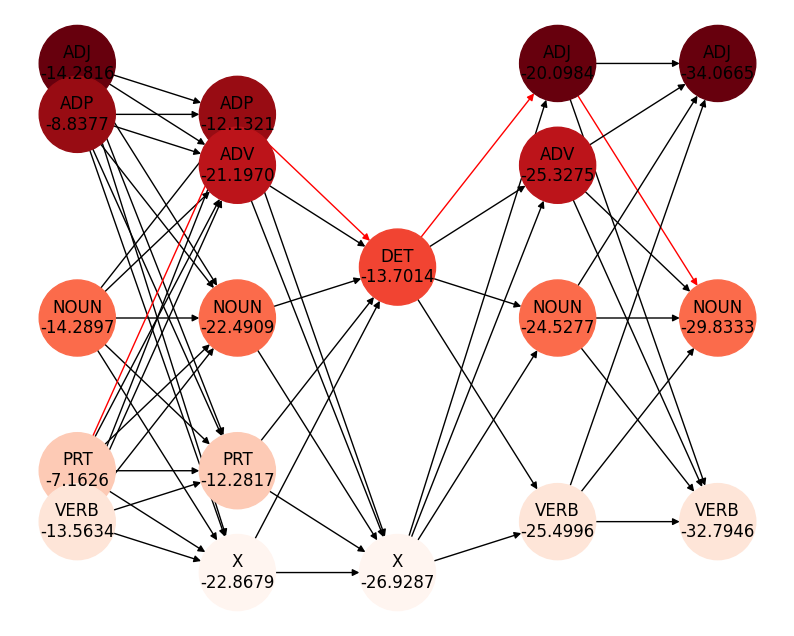

In [92]:
trellis_ex.visualize(tags, X_trellis_ex)

# CRF

The code can be found at https://github.com/AiswaryaSrinivas/DataScienceWithPython/blob/master/CRF%20POS%20Tagging.ipynb

Definition of the feature functions.

In [93]:
def features(sentence,index):
    ### sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    return {
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper()==sentence[index]),
        'prev_word':'' if index==0 else sentence[index-1],
        'next_word':'' if index==len(sentence)-1 else sentence[index+1],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',sentence[index])))),
        'prefix_1':sentence[index][0],
        'prefix_2': sentence[index][:2],
        'prefix_3':sentence[index][:3],
        'prefix_4':sentence[index][:4],
        'suffix_1':sentence[index][-1],
        'suffix_2':sentence[index][-2:],
        'suffix_3':sentence[index][-3:],
        'suffix_4':sentence[index][-4:],
        'word_has_hyphen': 1 if '-' in sentence[index] else 0  
    }

In [94]:
def untag(sentence):
    return [word for word,tag in sentence]

def prepareData(tagged_sentences):
    X,y=[],[]
    for sentences in tagged_sentences:
        X.append([features(untag(sentences), index) for index in range(len(sentences))])
        y.append([tag for word,tag in sentences])
    return X,y

In [95]:
X_train,y_train=prepareData(train_data)
X_test,y_test=prepareData(test_data)

A visualization of the obtained data is provided.

In [96]:
X_train[0]

[{'is_first_capital': 1,
  'is_first_word': 1,
  'is_last_word': 0,
  'is_complete_capital': 0,
  'prev_word': '',
  'next_word': 'is',
  'is_numeric': 0,
  'is_alphanumeric': 0,
  'prefix_1': 'H',
  'prefix_2': 'He',
  'prefix_3': 'He',
  'prefix_4': 'He',
  'suffix_1': 'e',
  'suffix_2': 'He',
  'suffix_3': 'He',
  'suffix_4': 'He',
  'word_has_hyphen': 0},
 {'is_first_capital': 0,
  'is_first_word': 0,
  'is_last_word': 0,
  'is_complete_capital': 0,
  'prev_word': 'He',
  'next_word': 'a',
  'is_numeric': 0,
  'is_alphanumeric': 0,
  'prefix_1': 'i',
  'prefix_2': 'is',
  'prefix_3': 'is',
  'prefix_4': 'is',
  'suffix_1': 's',
  'suffix_2': 'is',
  'suffix_3': 'is',
  'suffix_4': 'is',
  'word_has_hyphen': 0},
 {'is_first_capital': 0,
  'is_first_word': 0,
  'is_last_word': 0,
  'is_complete_capital': 0,
  'prev_word': 'is',
  'next_word': 'member',
  'is_numeric': 0,
  'is_alphanumeric': 0,
  'prefix_1': 'a',
  'prefix_2': 'a',
  'prefix_3': 'a',
  'prefix_4': 'a',
  'suffix_1': 

In [97]:
y_train[0]

['PRON',
 'VERB',
 'DET',
 'NOUN',
 'DET',
 'ADP',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'NOUN',
 'CONJ',
 'ADP',
 'DET',
 'ADJ',
 'ADJ',
 'NOUN',
 '.',
 '.']

The weights are evaluated using a gradient descent with with the L-BFGS method (lbfgs).

In [98]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass

F1 score for the test data:

In [99]:
y_pred=crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,average='weighted',labels=crf.classes_)

0.977845734764516

F1 score for the training data:

In [100]:
y_pred_train=crf.predict(X_train)
metrics.flat_f1_score(y_train, y_pred_train,average='weighted',labels=crf.classes_)

0.9909720907779643